# Student Graduation Prediction
In this notebook, we will look at if combining the two targets; Enrolled and Graduate, could make the model predict more accurately.

The main goal of the model we are trying to make is to predict whether someone will drop out or not. Therefore, it is not that interesting finding out if a student is either enrolled or graduated, and perhaps the models could perform better when these targets are combined.

In [68]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import shap

In [69]:
df = pd.read_csv('data/data.csv',sep=";")

target_map = {'Dropout': 1, 'Enrolled': 0, 'Graduate': 0}
y = df['Target'].map(target_map).astype(int).values
class_names = ['Not Dropped Out', 'Dropped Out']

X = df.drop(columns=['Target'])


In [70]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # ratios
        X["approval_ratio_1st"] = X["Curricular units 1st sem (approved)"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
        X["approval_ratio_2nd"] = X["Curricular units 2nd sem (approved)"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
        # avg grade across semesters (ignore zeros)
        X["avg_grade"] = X[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].replace(0, np.nan).mean(axis=1)
        # totals & overall ratio
        X["total_approved"] = X["Curricular units 1st sem (approved)"] + X["Curricular units 2nd sem (approved)"]
        X["total_enrolled"] = X["Curricular units 1st sem (enrolled)"] + X["Curricular units 2nd sem (enrolled)"]
        X["total_approval_ratio"] = X["total_approved"] / X["total_enrolled"].replace(0, np.nan)

        X["approval_diff"] = X["approval_ratio_2nd"] - X["approval_ratio_1st"]
        X["grade_diff"] = X["Curricular units 2nd sem (grade)"] - X["Curricular units 1st sem (grade)"]

        return X.fillna(0.0)

X = X.fillna(0)

In [71]:
categorical_cols = [
    "Application mode", "Application order", "Course",
    "Previous qualification", "Nationality", "Mother's qualification",
    "Father's qualification", "Mother's occupation", "Father's occupation",
    "Displaced", "Debtor", "Tuition fees up to date", "Scholarship holder",
    "Gender", "International", "Marital status", "Daytime/evening attendance\t",
    "Educational special needs"
]
categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [73]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

classes = np.unique(y_train)
class_counts = np.bincount(y_train)
class_weights = (class_counts.sum() / (len(classes) * class_counts))
sample_weight = class_weights[y_train]

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

pipe_xgb = ImbPipeline([
    ("fe", FeatureEngineer()),
    # ("pre", preprocess),
    ("clf", xgb),
])

pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)

print("=== XGBoost ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

=== XGBoost ===
Accuracy: 0.8949
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.95      0.92       601
    Dropped Out       0.87      0.79      0.83       284

       accuracy                           0.89       885
      macro avg       0.89      0.87      0.88       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[569  32]
 [ 61 223]]


In [74]:
pipe_xgb_smote = ImbPipeline([
    ("fe", FeatureEngineer()),
    # ("pre", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb),
])

pipe_xgb_smote.fit(X_train, y_train)
y_pred_sm = pipe_xgb_smote.predict(X_test)

print("\n=== XGBoost + SMOTE ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_sm):.4f}")
print(classification_report(y_test, y_pred_sm, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_sm))

D:\PycharmProjects\tdt4259\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== XGBoost + SMOTE ===
Accuracy: 0.8927
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.93      0.92       601
    Dropped Out       0.84      0.82      0.83       284

       accuracy                           0.89       885
      macro avg       0.88      0.87      0.88       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[556  45]
 [ 50 234]]


In [75]:
catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="Accuracy",
    random_state=42,
    verbose=False
)

pipe_catboost_smote = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost_smote.fit(X_train, y_train)
y_pred_cat = pipe_catboost_smote.predict(X_test)

print("\n=== CatBoost ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_cat):.4f}")
print(classification_report(y_test, y_pred_cat, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_cat))



=== CatBoost ===
Accuracy: 0.8904
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.86      0.78      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[566  35]
 [ 62 222]]


In [76]:
lgbm_clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    objective="binary",
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
)

pipe_lgbm = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", lgbm_clf),
])

pipe_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipe_lgbm.predict(X_test)

print("\n=== LightGBM + SMOTE ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_lgbm):.4f}")
print(classification_report(y_test, y_pred_lgbm, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lgbm))

D:\PycharmProjects\tdt4259\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2402, number of negative: 2402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3948
[LightGBM] [Info] Number of data points in the train set: 4804, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM + SMOTE ===
Accuracy: 0.8836
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.92      0.91       601
    Dropped Out       0.82      0.81      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.86      0.87       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[552  49]
 [ 54 230]]


### Learning from the Models
It is also important to look at what features makes the most impact on the model. Beneath, we will look at the top 10 most important features for the best performing model above: XGBoost (without SMOTE). We will also have a look at which features could be harmful and see if removing those features could improve accuracy.

ROC-AUC: 0.9375


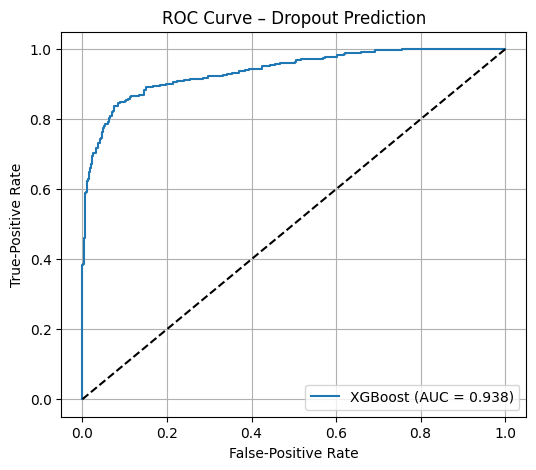

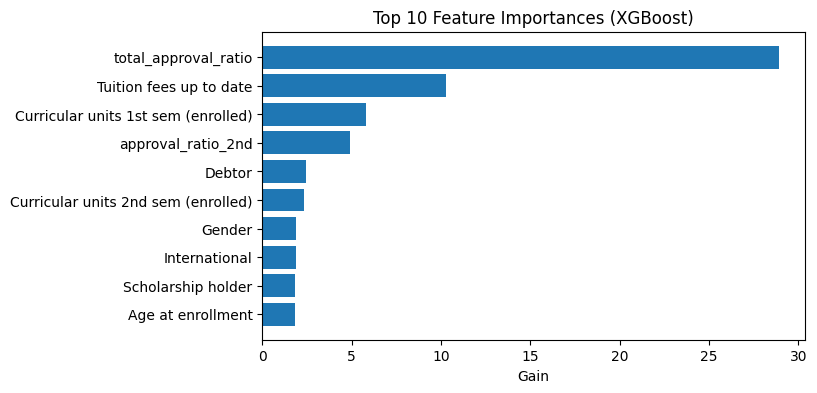

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve

# Probabilities for the positive class (Dropped Out)
y_proba = pipe_xgb.predict_proba(X_test)[:, 1]

# --- Metrics ---
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()

# --- Top-10 feature importances ---
booster = pipe_xgb.named_steps["clf"].get_booster()
importance = booster.get_score(importance_type="gain")
importance_df = (
    pd.DataFrame(list(importance.items()), columns=["Feature", "Gain"])
    .sort_values("Gain", ascending=False)
    .head(10)
)
plt.figure(figsize=(7, 4))
plt.barh(importance_df["Feature"], importance_df["Gain"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Gain")
plt.show()


🔻 Features potentially hurting the model (lowest permutation importance):
                                           Feature  Importance_Mean  \
8                           Mother's qualification        -0.001694   
23          Curricular units 1st sem (evaluations)        -0.001060   
7                                      Nationality        -0.000714   
15                                          Debtor        -0.000545   
0                                   Marital status        -0.000500   
32  Curricular units 2nd sem (without evaluations)        -0.000114   
34                                  Inflation rate        -0.000035   
14                       Educational special needs         0.000005   
6                   Previous qualification (grade)         0.000066   
1                                 Application mode         0.000110   

    Importance_Std  
8         0.000614  
23        0.001307  
7         0.000344  
15        0.001163  
0         0.000402  
32        0.000128

C:\Users\willi\AppData\Local\Temp\ipykernel_33580\471733901.py:27: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\PycharmProjects\tdt4259\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


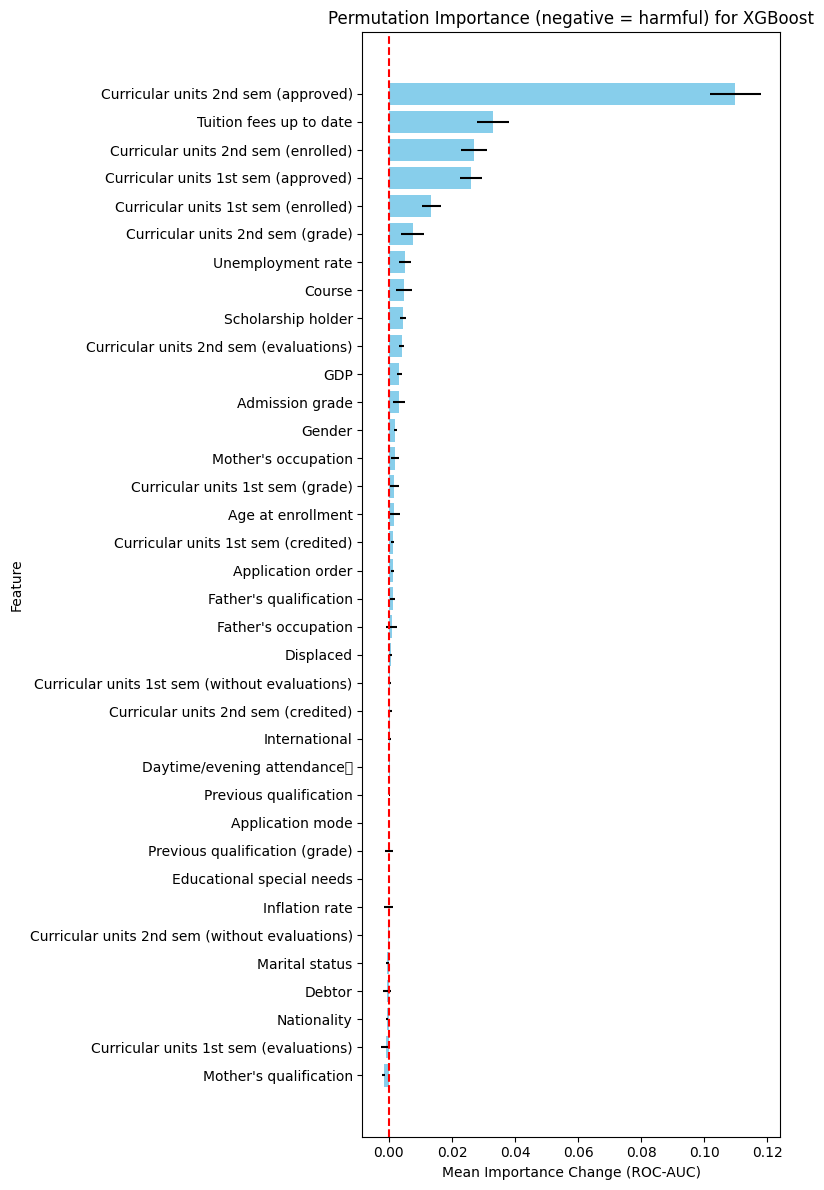

In [77]:
from sklearn.inspection import permutation_importance

# Evaluate permutation importance on test set
r = permutation_importance(
    pipe_xgb, X_test, y_test,
    scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=-1
)

# Collect results
imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": r.importances_mean,
    "Importance_Std": r.importances_std
}).sort_values("Importance_Mean", ascending=True)  # ascending -> bad at top

# --- Show 10 worst features ---
print("🔻 Features potentially hurting the model (lowest permutation importance):")
print(imp_df.head(10))

# --- Plot full spectrum ---
plt.figure(figsize=(8, 12))
plt.barh(imp_df["Feature"], imp_df["Importance_Mean"], xerr=imp_df["Importance_Std"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Permutation Importance (negative = harmful) for XGBoost")
plt.xlabel("Mean Importance Change (ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [66]:
harmful_features = [
    "Mother's qualification",
    "Application mode",
    "Previous qualification",
    "Curricular units 2nd sem (without evaluations)",
    "Marital status",
    "Nationality",
    "Inflation rate",
    "Daytime/evening attendance\t",
    "International",
    "Educational special needs",
]

X_cleaned = X.drop(columns=harmful_features, errors="ignore")

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cleaned, y, stratify=y, test_size=0.2, random_state=42
)

pipe_xgb_clean = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.08,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )),
])

pipe_xgb_clean.fit(X_train_c, y_train_c)
y_pred_c = pipe_xgb_clean.predict(X_test_c)
y_proba_c = pipe_xgb_clean.predict_proba(X_test_c)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print("=== XGBoost (Cleaned Feature Set) ===")
print("Accuracy:", f"{accuracy_score(y_test_c, y_pred_c):.4f}")
print("ROC-AUC:", f"{roc_auc_score(y_test_c, y_proba_c):.4f}")
print(classification_report(y_test_c, y_pred_c, target_names=class_names))


=== XGBoost (Cleaned Feature Set) ===
Accuracy: 0.8938
ROC-AUC: 0.9383
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.95      0.92       601
    Dropped Out       0.87      0.79      0.83       284

       accuracy                           0.89       885
      macro avg       0.89      0.87      0.87       885
   weighted avg       0.89      0.89      0.89       885

